In [87]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize

def lnprob(x,ivar): #ivar = 1/variance from each dimension
    return -0.5*np.sum(ivar*x**2)

ndim = 10
nwalkers = 100

ivar = 1./np.random.rand(ndim)
p0 = [np.random.rand(ndim) for i in range(nwalkers)] #Monte Carlo step
sampler =  emcee.EnsembleSampler(nwalkers, ndim, lnprob,args=[ivar])
pos,prob,state = sampler.run_mcmc(p0,100)

In [88]:
sampler.reset()
runned = sampler.run_mcmc(pos,1000)

In [89]:
flatchain = sampler.flatchain
for i in range(ndim):
    plt.figure()
    plt.hist(flatchain[:,i],100,color="k",histtype='step')
    plt.title("Dimension {0:d}".format(i))
plt.show()

## Example 2: Fitting a function model

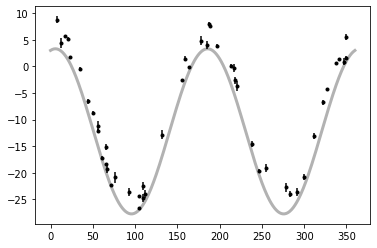

In [132]:
# choose the true parameters:
A_true=15.22
B_true = -12.2
C_true = -3.1


N = 50
x = np.sort(360*np.random.rand(N))
yerr = 0.1+0.9*np.random.rand(N)
y =  A_true*np.cos(np.radians(2*x))-C_true*np.sin(np.radians(2*x))+B_true
y += yerr*np.random.rand(N)+5*np.random.rand(N)


plt.errorbar(x,y,yerr=yerr, fmt='k.',capsize =0)

x0 = np.linspace(0,360,361)
plt.plot(x0, A_true*np.cos(np.radians(2*x0))-C_true*np.sin(np.radians(2*x0))+B_true,'k', alpha=0.3, lw=3)

plt.show()

In [178]:
def ln_likelihood(theta,x,y,yerr):
    A,B,C = theta
    model = A*np.cos(np.radians(2*x))-C*np.sin(np.radians(2*x))+B
    LL = -0.5*np.sum((y-model)**2/yerr**2)
    return LL  

15.92853603100573 -9.68204071735158 -2.455276981351668


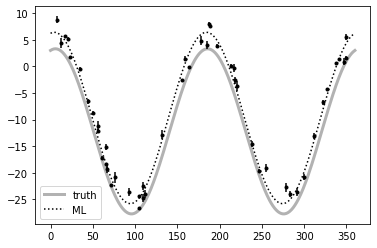

In [179]:
np.random.seed(42)
nll = lambda*args: -ln_likelihood(*args)
inital =np.array([A_true, B_true, C_true])+0.1*np.random.randn(3)

soln = minimize(nll, inital, args=(x,y,yerr))
A_ml,B_ml,C_ml =  soln.x

print(A_ml,B_ml,C_ml)

plt.errorbar(x,y,yerr=yerr, fmt='k.',capsize =0)
x0 = np.linspace(0,360,361)
plt.plot(x0, A_true*np.cos(np.radians(2*x0))-C_true*np.sin(np.radians(2*x0))+B_true, 'k', alpha=0.3, lw=3,label="truth")
plt.plot(x0, A_ml*np.cos(np.radians(2*x0))-C_ml*np.sin(np.radians(2*x0))+B_ml,":k",label='ML')
plt.legend()
plt.show()

In [180]:
def lnprior(theta):
    A,B,C= theta
    if 10<A<20 and -15<B<-5 and -110<C<0:
        return 0.0
    else:
        return -np.inf
    
def lnprob(theta,x,y,yerr):
    lp = lnprior(theta)
    if np.isfinite(lp):
        return lp+ln_likelihood(theta,x,y,yerr)
    return -np.inf

In [181]:
pos0= soln.x+1e-4*np.random.randn(50,3)
nwalkers,ndim = 50,3

sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(x,y,yerr))
pos,prob,state = sampler.run_mcmc(pos0,100)

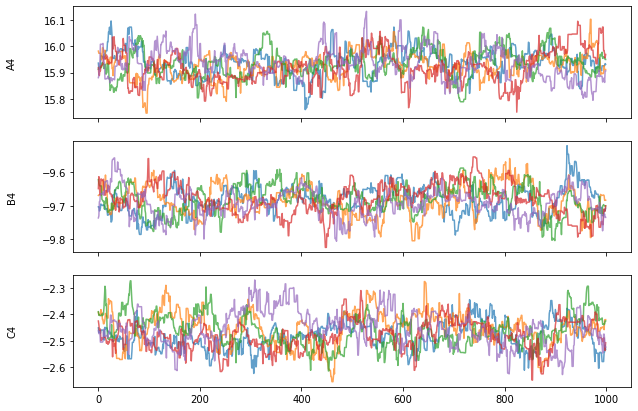

In [182]:
sampler.reset()
runned = sampler.run_mcmc(pos,1000)
samples= sampler.get_chain()
labels = ['A','B','C']

fig,axes = plt.subplots(3,figsize=(10,7),sharex=True)
for i in range(ndim):
    ax = axes[i]
    for w in range(5):
        ax.plot(samples[:,w,i], alpha=0.7)
#     ax.set_xlim(0,len(samples))
        ax.set_ylabel(labels[i]+str(w))
        ax.yaxis.set_label_coords(-0.1,0.5)

plt.show()

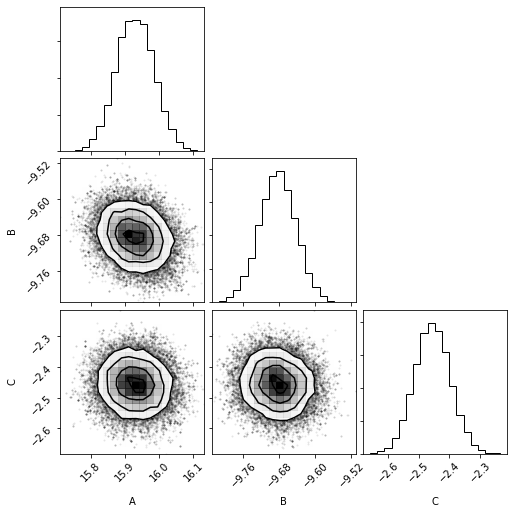

In [183]:
flat_samples= sampler.flatchain

fig = corner.corner(flat_samples, labels=labels,truths=[A_true,B_true,C_true])